In [ ]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
#Download the required packages and the data that we will use
#for this tutorial

!pip install netCDF4
# !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
# !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

In [ ]:
#Download Nino3.4 index (this index measures the state of ENSO by encoding the average
#temperature anomaly in the equatorial Pacific)
!gdown --id 1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t
To: /content/nino34.long.anom.data.txt
100% 15.4k/15.4k [00:00<00:00, 49.3MB/s]


In [ ]:
#Download sst observations from 1880 to 2018
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc

Downloading...
From (original): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
From (redirected): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc&confirm=t&uuid=29c570e9-63bc-4c3c-b323-c77ac7651829
To: /content/sst.mon.mean.trefadj.anom.1880to2018.nc
100% 432M/432M [00:04<00:00, 90.2MB/s]


In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time,
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]

  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    #TODO: create an option to apply the PCA operation learned
    #on the train set to the test set.  Currently, PCA is performed
    #independently on the train set and test set.
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead,
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()



In [ ]:
# Sample loading of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)


In [ ]:
from sklearn.linear_model import LinearRegression
import time
# Define the model
linear_model = LinearRegression()

# Train the linear regression model
linear_model.fit(X_train, y_train)

# Optionally, make predictions
predictions = linear_model.predict(X_test)

# Train the stacking model and measure fit time
start_time = time.time()
linear_model.fit(X_train, y_train)
fit_time = time.time() - start_time

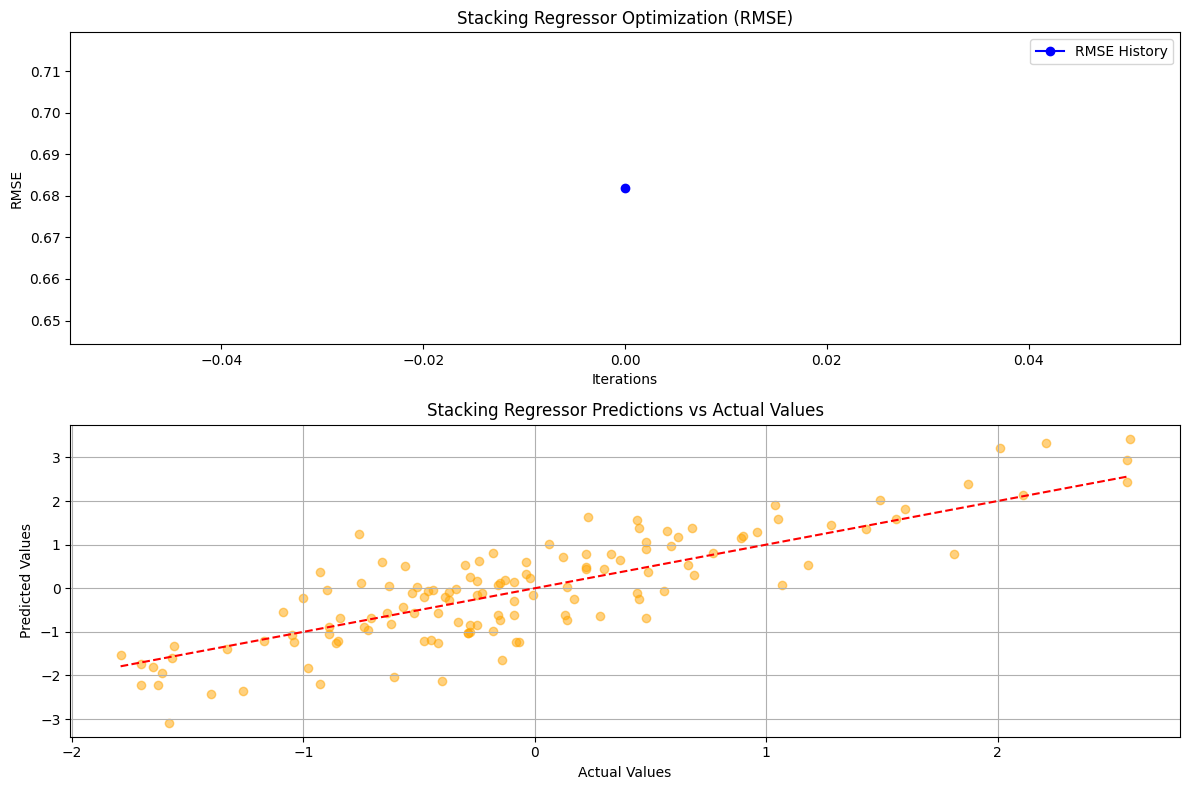

Fit time (seconds): 4.6889
RMSE: 0.6818, MSE: 0.4649, R²: 0.4682


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Make predictions
y_pred = linear_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


#Add a layer of visualization to compare with PSO model
rmse_history = [rmse]  # You can extend this with multiple iterations if available

# Visualization
plt.figure(figsize=(12, 8))

# Plot RMSE history
plt.subplot(2, 1, 1)
plt.plot(rmse_history, label='RMSE History', color='blue', marker='o')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Stacking Regressor Optimization (RMSE)')
plt.legend()

# Plot Predictions vs Actual
plt.subplot(2, 1, 2)
plt.scatter(y_test, y_pred, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Stacking Regressor Predictions vs Actual Values')
plt.grid()

plt.tight_layout()
plt.show()

# Print results
print(f"Fit time (seconds): {fit_time:.4f}")
print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")


